### Following idea of single feature binary decoding, should look at how many sessions have more than N blocks of a rule


In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *

import seaborn as sns
import scipy.stats


In [19]:
num_bins = 2
SESS_SPIKES_PATH = "/data/patrick_res/firing_rates/{sub}/{sess_name}_{fr_type}_{pre_interval}_{event}_{post_interval}_{interval_size}_bins_1_smooth.pickle"


def get_sess_beh(row, beh_path, sub, check_sess_has_frs=False):
    session = row.session_name
    behavior_path = beh_path.format(sess_name=session, sub=sub)
    beh = pd.read_csv(behavior_path)

    # # filter trials 
    beh = behavioral_utils.get_valid_trials(beh)
    if len(beh) == 0:
        return None
    if check_sess_has_frs:
        spikes_path = SESS_SPIKES_PATH.format(
            sub=sub,
            sess_name=session, 
            fr_type="firing_rates",
            pre_interval=1000, 
            event="StimOnset", 
            post_interval=1000, 
            interval_size=100
        )
        print(spikes_path)
        if not os.path.exists(spikes_path):
            return None
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_beliefs_per_session(beh, session, sub)
    beh = behavioral_utils.get_belief_value_labels(beh)
    beh["session"] = session
    return beh

In [20]:
sub = "BL"
beh_path = SESS_BEHAVIOR_PATH

if sub == "SA":
    # Monkey S
    SESSIONS_PATH = "/data/patrick_res/sessions/SA/valid_sessions.pickle"
    sessions = pd.read_pickle(SESSIONS_PATH)
    all_beh = pd.concat(sessions.apply(lambda x: get_sess_beh(x, beh_path, "SA"), axis=1).values).reset_index()
elif sub == "BL":
    # Monkey B
    # all_units = pd.read_pickle("/data/patrick_res/firing_rates/BL/all_units.pickle")
    # sessions = pd.DataFrame({"session_name": all_units.session.unique()})
    sessions = pd.read_pickle("/data/patrick_res/sessions/BL/valid_sessions.pickle")
    res = sessions.apply(lambda x: get_sess_beh(x, beh_path, "BL", check_sess_has_frs=True), axis=1)
    res = res[~res.isna()]
    all_beh = pd.concat(res.values).reset_index()
else: 
    raise ValueError()

/data/patrick_res/firing_rates/BL/20190128_firing_rates_1000_StimOnset_1000_100_bins_1_smooth.pickle
/data/patrick_res/firing_rates/BL/20190625_firing_rates_1000_StimOnset_1000_100_bins_1_smooth.pickle
/data/patrick_res/firing_rates/BL/20191010_firing_rates_1000_StimOnset_1000_100_bins_1_smooth.pickle
/data/patrick_res/firing_rates/BL/20190312_firing_rates_1000_StimOnset_1000_100_bins_1_smooth.pickle
/data/patrick_res/firing_rates/BL/20190816_firing_rates_1000_StimOnset_1000_100_bins_1_smooth.pickle
/data/patrick_res/firing_rates/BL/20190823_firing_rates_1000_StimOnset_1000_100_bins_1_smooth.pickle
/data/patrick_res/firing_rates/BL/20190619_firing_rates_1000_StimOnset_1000_100_bins_1_smooth.pickle
/data/patrick_res/firing_rates/BL/20190709_firing_rates_1000_StimOnset_1000_100_bins_1_smooth.pickle
/data/patrick_res/firing_rates/BL/20190603_firing_rates_1000_StimOnset_1000_100_bins_1_smooth.pickle
/data/patrick_res/firing_rates/BL/20190320_firing_rates_1000_StimOnset_1000_100_bins_1_smoo

In [21]:
all_beh

,index,TrialNumber,BlockNumber,TrialAfterRuleChange,TaskInterrupt,ConditionNumber,Response,ItemChosen,TrialType,CurrentRule,...,ESCHERProb,POLKADOTProb,RIPPLEProb,SWIRLProb,BeliefStateValue,BeliefStateValueBin,PreferredBelief,BeliefStateValueLabel,PreferredChosen,session
0,0,27,2,0,NaN,3698,Incorrect,2.0,6,YELLOW,...,0.047355,0.016991,0.026388,0.023243,0.544836,1,CYAN,High CYAN,False,20190128
1,1,28,2,1,NaN,3871,Incorrect,2.0,6,YELLOW,...,0.059105,0.014452,0.041241,0.038562,0.507766,1,CYAN,High CYAN,False,20190128
2,2,29,2,2,NaN,3975,Incorrect,1.0,6,YELLOW,...,0.069315,0.031161,0.023503,0.051762,0.481420,1,CYAN,High CYAN,True,20190128
3,3,30,2,3,NaN,3852,Incorrect,2.0,6,YELLOW,...,0.104462,0.060822,0.022639,0.084385,0.418154,0,CYAN,Low,False,20190128
4,4,31,2,4,NaN,3891,Incorrect,1.0,6,YELLOW,...,0.107958,0.070709,0.016575,0.090821,0.417044,0,CYAN,Low,True,20190128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21485,88,150,3,81,NaN,3829,Correct,0.0,6,YELLOW,...,0.043605,0.020507,0.030682,0.025258,0.537880,1,YELLOW,High YELLOW,True,20190123
21486,89,151,3,82,NaN,3679,Correct,0.0,6,YELLOW,...,0.063663,0.017939,0.022231,0.019943,0.539393,1,YELLOW,High YELLOW,True,20190123
21487,90,152,3,83,NaN,3504,Correct,0.0,6,YELLOW,...,0.083443,0.016921,0.018738,0.017769,0.541134,1,YELLOW,High YELLOW,True,20190123
21488,91,153,3,84,NaN,3984,Correct,0.0,6,YELLOW,...,0.045601,0.016837,0.040527,0.017204,0.547438,1,YELLOW,High YELLOW,True,20190123


In [22]:
block_thresh = 3
good_sess = behavioral_utils.get_good_sessions_per_rule(all_beh, block_thresh)


In [24]:
good_sess

,feat,sessions,num_sessions
0,CIRCLE,"[20190606, 20190703]",2
1,SQUARE,"[20190524, 20190530, 20190702]",3
2,STAR,"[20190128, 20190226, 20190524, 20190605, 20190...",8
3,TRIANGLE,"[20190606, 20190702, 20190709, 20190710, 20190...",5
4,CYAN,"[20190207, 20190531, 20190617, 20190627, 20190...",5
5,GREEN,[20190815],1
6,MAGENTA,"[20190530, 20190703, 20190815, 20190823]",4
7,YELLOW,"[20190524, 20190605, 20190617, 20190703, 20190...",5
8,ESCHER,"[20190220, 20190226, 20190529, 20190530, 20190...",11
9,POLKADOT,"[20190531, 20190605, 20190606, 20190816]",4


In [25]:
good_sess.to_pickle(f"/data/patrick_res/sessions/{sub}/feats_at_least_{block_thresh}blocks.pickle")

### For each session, for each rule, what are the min number of trials that match: 
- high preferred features
- high conf trials where features are chosen but not preferred. 

In [9]:
def min_trials_per_session(row, filt_pref_chosen):
    res = []
    for sess in row.sessions:
        beh = all_beh[all_beh.session == sess]
        if filt_pref_chosen: 
            beh["PrefChosen"] = beh.apply(lambda x: x[FEATURE_TO_DIM[x.PreferredBelief]] == x.PreferredBelief, axis=1)
            beh = beh[beh.PrefChosen]
        pref = behavioral_utils.get_chosen_preferred_single(row.feat, beh, high_val_only=False)
        min_pref = np.min(pref.groupby("Choice").count().TrialNumber)

        not_pref = behavioral_utils.get_chosen_not_preferred_single(row.feat, beh, high_val_only=False)
        min_not_pref = np.min(not_pref.groupby("Choice").count().TrialNumber)

        min_all = np.min((min_pref, min_not_pref))

        res.append({
            "feat": row.feat, 
            "session": sess, 
            "min_pref": min_pref, 
            "min_not_pref": min_not_pref,
            "min_all": min_all
        })
    return pd.DataFrame(res)
        
min_trials = pd.concat(good_sess.apply(lambda x: min_trials_per_session(x, filt_pref_chosen=False), axis=1).values)
min_trials["type"] = "all"

min_trials_pref_chosen = pd.concat(good_sess.apply(lambda x: min_trials_per_session(x, filt_pref_chosen=True), axis=1).values)
min_trials_pref_chosen["type"] = "pref_chosen"

all = pd.concat((min_trials, min_trials_pref_chosen))



In [7]:
min_trials.sort_values(by="min_all")

,feat,session,min_pref,min_not_pref,min_all
4,MAGENTA,20180803,33,275,33
16,MAGENTA,20180928,34,159,34
18,GREEN,20181009,41,190,41
21,YELLOW,20181002,42,242,42
4,CIRCLE,20180803,43,270,43
...,...,...,...,...,...
7,YELLOW,20180821,152,241,152
4,CYAN,20180820,162,192,162
15,YELLOW,20180912,165,228,165
20,MAGENTA,20181005,165,250,165


In [12]:
all

,feat,session,min_pref,min_not_pref,min_all,type
0,CIRCLE,20180615,49,137,49,all
1,CIRCLE,20180625,74,109,74,all
2,CIRCLE,20180709,79,167,79,all
3,CIRCLE,20180802,93,285,93,all
4,CIRCLE,20180803,43,270,43,all
...,...,...,...,...,...,...
8,SWIRL,20180828,111,81,81,pref_chosen
9,SWIRL,20180829,81,59,59,pref_chosen
10,SWIRL,20180904,92,103,92,pref_chosen
11,SWIRL,20180906,71,101,71,pref_chosen


<Axes: xlabel='min_all', ylabel='Count'>

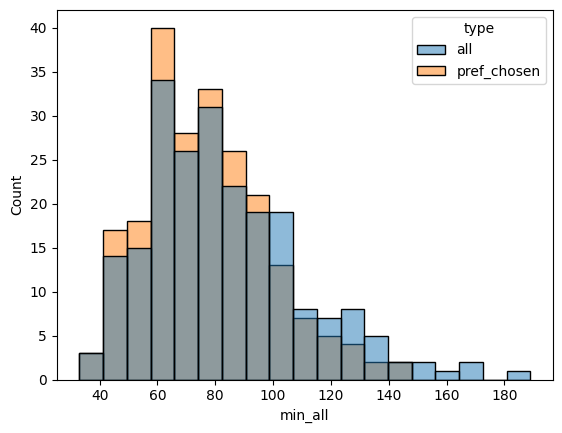

In [13]:
sns.histplot(all, x="min_all", hue="type")

### Save files